In [1]:
import sys
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from functools import partial

In [2]:
# Import data, custom figure-making functions
sys.path.append('/mnt/d/orchards')
from figure_constants import *
from figure_functions import *
sys.path.append(installDir+'scripts')
from chartannotator import add_stat_annotation

loading subjects...
loading samples...
loading segments...
loading genes...
loading SNPs...
loading transmission pairs...
loading transmission segments...
loading transmission SNPs...


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (58) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
transmissionPairs.distance /= 2
transmissionSNPs = transmissionSNPs.rename(columns={'N_sites_gene_index':'N_sites_gene', 'S_sites_gene_index':'S_sites_gene'})

In [4]:
def bootstrap(df, n, y):
    data = df.sample(n, replace=True)[y]
    return data.mean()

def boostrap_mean_and_ci(data, var, label, bootstrap_size=10000):
    mean = data[var].mean()
    bootstraps = np.array([bootstrap(data, len(data), var) for _ in range(bootstrap_size)])
    ci = np.percentile(mean-bootstraps, (5, 95))
    return {var: mean, 'ci_low': -ci[0], 'ci_high':ci[1], 'Pairing': label, 'data':bootstraps}

In [5]:

# random_state = tuple(np.load('/mnt/d/orchards/h1n1/figures/fig_five_rng_state.npy', allow_pickle=True))
# np.random.set_state(random_state)
# tuple(random_state)

In [6]:
subtype = 'H3N2'

transmissionSNPs = transmissionSNPs.loc[(transmissionSNPs.kind=='transmission')&(transmissionSNPs.subtype==subtype)]
transmissionPairs = transmissionPairs.loc[(transmissionPairs.kind=='transmission')&(transmissionPairs.subtype==subtype)]

(0.0, 0.05)

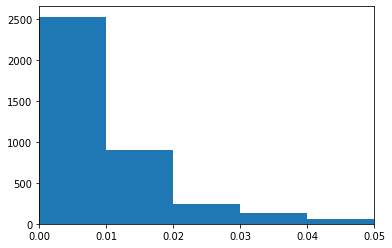

In [7]:
# transmittedSNPs = transmissionSNPs.loc[transmissionSNPs.abs_SNP_frequency_difference >= 0.01]
plt.hist(transmissionSNPs.abs_SNP_frequency_difference.values, bins=100)
plt.xlim(0,.05)

<ipython-input-8-29534cda481b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transmissionPairs['log_distance'] = np.log10(transmissionPairs['distance'])


<AxesSubplot:ylabel='log_distance'>

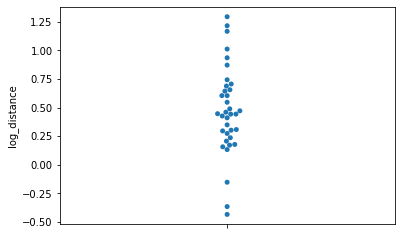

In [8]:
from scipy import stats

transmissionPairs['log_distance'] = np.log10(transmissionPairs['distance'])

sns.swarmplot(data=transmissionPairs, y='log_distance')


In [9]:
from matplotlib.collections import PolyCollection as poly

def prob_range_violin_plot_vert(ax, x, y, hue=None, data=None, order=None, bootstrapped_random_data=None, half_violins=True, linecolor=snsred, lwidth=3, mc=True):
    df = data
    
    violindf=bootstrapped_random_data.replace(np.nan, 0).replace(np.inf, 0).replace(-np.inf, 0)
    violindf=violindf.sort_values(y)
    ax = sns.violinplot(ax=ax, order=order,data=violindf, bw=.4,scale="count", split=True,cut=0,x=x, y=y, inner=None)
    if half_violins:
        for b in ax.get_children():
            if type(b) == poly:
        #         print (b.get_paths()[0].vertices)
                m = np.mean(b.get_paths()[0].vertices[:,1])
                
                # modify the paths to not go further right than the center
                b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], -np.inf, m)+.2
                b.set_color(snsblue)
    if mc:
        df = calcFDRsignificance(df.rename(columns={'pvalue_log_diff_high':'pvalue_greater_than', 'pvalue_log_diff_low':'pvalue_less_than'}))
    else:
        df['pass'] = True
        df['corrected_pvalue'] = df['pvalue_log_diff']
        
    yunits = 1/len(df)
    starmax=0
    xlims = ax.get_xlim()
    xrange = xlims[1]-xlims[0]
    if hue:
        offset=.75
        df = df.sort_values([y,hue])
        hueadjust=2
        staradjust = 0.047
    else:
        offset=.3
        df = df.sort_values(y)
        hueadjust=1
        staradjust = 0.082
    for dfpos, vals in enumerate(df.iterrows()):
        _, row = vals
        ypos = order.index(row[y])
        if hue:
            side = ypos%2
            start = (ypos-offset+1)*yunits
            end = (ypos-0.005*lwidth+1)*yunits
            starpos = (ypos)/hueadjust-offset/(hueadjust*2)
            if ypos%2==1:
                start = (ypos+0.005*lwidth)*yunits
                end = (ypos+offset)*yunits
                starpos = (ypos-1)/hueadjust+offset/(hueadjust*2)
        else:
            start = 1-(ypos-offset+.398)*yunits
            end = 1-(ypos+offset+.398)*yunits
            
            starpos = ypos-.07

        
        truth = row[x]
        
        range_max = violindf.loc[violindf[y]==order[ypos], x].max()
        range_min = violindf.loc[violindf[y]==order[ypos], x].min()
        pval = row.corrected_pvalue
        
        ax.axvline(truth, ymin=start, ymax=end, color=linecolor,linewidth=lwidth,alpha=0.9)
        stars=0
        if not row['pass']:
            stars=0
        elif pval < 0.0001:
            stars=4
        elif pval < 0.001:
            stars=3
        elif pval < 0.01:
            stars=2
        elif pval < .05:
            stars=1
        star_y = starpos
        star_x = max(range_max,truth)+xrange*.03
        if (pval<0.05) & (stars==0):
            print (f'{order[ypos]} excluded due to failing FDR test (pvalue={pval})')
        if stars > 0:
            if pval == 0:
                star_text = f'p < 0.001'#'*'*stars
            else:
                star_text = f'p = {round(pval, 4)}'#'*'*stars
        else:
            star_text = ''
        ax.text(x=star_x, y=star_y, s=star_text, fontsize=font_annotation_size, verticalalignment='center')

    return ax

# minimum allele frequency is used as a pseudocount here when synon/nonsynon divergence in a gene pairing is 0
def calc_pairing_divergences(transmittedSNPs, pairings, subtype='H3N2', freq_cutoff=0.01):
    # First, calculate divergences only using SNPs that are above the freq cutoff
    transmittedSNPs = transmittedSNPs.loc[transmittedSNPs.abs_SNP_frequency_difference >= freq_cutoff]
    
    # Next, in order to account for gene pairings with no differences between them
    # (and thus aren't reprsented in the transmittedSNPs dataframe), 
    # I will make a separate dataframe of id columns that contain all possible pairing/gene/AAtype combinations.
    all_possible_products = pd.DataFrame(transmittedSNPs.loc[transmittedSNPs.subtype == subtype,'product'].dropna().unique())
    AAtypes = pd.DataFrame(['Nonsynonymous', 'Synonymous'])

    # in case a pairing has no differences at all, I will use a separate list of pairings
    transmittedSNPs['pairing_id'] = transmittedSNPs['index'] + '|' + transmittedSNPs.contact
    pairing_ids = pairings['index']+ '|' + pairings.contact 

    # actually create the dataframe of possible combinations
    pairing_divergence = all_possible_products.merge(AAtypes, how='cross').merge(pd.DataFrame(pairing_ids).reset_index(drop=True), how='cross')
    pairing_divergence = pairing_divergence.rename(columns={'0_x':'product','0_y':'AAtype',0:'pairing_id'})
    
    # calc the sum of absolute SNP frequency changes (aka divergence) 
    # and merge with all possible combinations of pairings/genes/AAtypes. 
    # Combinations of id variables that have no changes will be nan, and so I will set those at 0.
    between_pairing_sum_of_frequencies = transmittedSNPs.groupby(['pairing_id', 'product', 'AAtype']).sum()['abs_SNP_frequency_difference'].reset_index().rename(columns={'abs_SNP_frequency_difference':'sum_divergence'})
    pairing_divergence = pairing_divergence.merge(between_pairing_sum_of_frequencies, on=['pairing_id','product', 'AAtype'], how='left')
    pairing_divergence.sum_divergence = pairing_divergence.sum_divergence.fillna(0)
    
    # I will normalize divergences to the number of synon/nonsynon sites in the *index* case. So first, identify index:
    pairing_divergence['sampleID'] = pairing_divergence.pairing_id.str.split('|').str[0]

    # And merge with the genes dataframe to add the number of synon/nonsynon sites per gene in the index cases.
    # There should not be any missing data here; I should previously have calculated this for all samples collected.
    pairing_divergence = pairing_divergence.merge(genes[['sampleID','product','N_sites_gene','S_sites_gene']], on=['sampleID','product'], how='left').rename(columns={'sampleID':'index'})

    # Now reorganize the synon/nonsynon sites data so that each row is either synon or nonsynon only
    pairing_divergence['sites'] = pairing_divergence.N_sites_gene
    pairing_divergence.loc[pairing_divergence.AAtype == 'Synonymous', 'sites'] = pairing_divergence.loc[pairing_divergence.AAtype == 'Synonymous', 'S_sites_gene'].values
    
    pairing_divergence['normalized_divergence'] = pairing_divergence.sum_divergence/pairing_divergence.sites
    
#   # To finish off calculating the total divergence, because I will be taking the log of these data, which are counts, 
#   # I have to deal with missing data (0s that are due to under-counting. Presumably 0s just represent regions that
#   # rarely aquire mutations. It is difficult to observe rate of mutation below a hard cutoff of 1/len of gene.
#   # One common way to deal with this is to add a pseudocount of the smallest possible observation to all observations.
#   # For this experiment, the smallest possible observation is one mutation between pairs of frequency "freq_cutoff".
#   # So I add that pseudocount here.
    pseudocount = freq_cutoff
    pairing_divergence.sum_divergence += pseudocount 
    
    # Finally, I can now normalize total divergence by the number of possible sites
    pairing_divergence['normalized_divergence_with_pseudocount'] = pairing_divergence.sum_divergence/pairing_divergence.sites
    
    # And I can calculate the log of the normalized divergece.
    pairing_divergence['log_divergence'] = np.log10(pairing_divergence.normalized_divergence_with_pseudocount)
    
    return pairing_divergence

def corrected_fdr_pvals(pvals, rejects, alpha=0.05):
    print(pvals)
    sortind = np.argsort(pvals)
    pvals_sorted = np.take(pvals, sortind)
    ecdfactor = 1/len(pvals)*np.arange(1, len(pvals)+1)
    rejectmax = max(np.nonzero(rejects[sortind])[0])
    pvals_corrected_raw = pvals_sorted / ecdfactor[rejectmax]

    return pvals_corrected_raw[np.argsort(sortind)]

def calcFDRsignificance(df, alpha=0.05):
    assert 'pvalue_less_than' in df.columns
    assert 'pvalue_greater_than' in df.columns
#     print (df.columns)
    if 'pvalue' not in df.columns:
        df['p_value'] = df.apply(lambda row: min(row.pvalue_less_than, row.pvalue_greater_than)*2,axis=1)
    df = df.sort_values('p_value').reset_index(drop=True)#.reset_index().rename(columns={'index':'p_value_rank'})
    df['p_value_rank'] = df.index+1
    number_of_comparisons = len(df)
    df['q_value'] = (df.p_value_rank/number_of_comparisons)*alpha
    threshold = df.loc[df.q_value>=df.p_value, 'p_value_rank'].max()
    df['pass'] = df.p_value_rank <= threshold
    
    df['corrected_pvalue'] = corrected_fdr_pvals(df.p_value.values, df['pass'].values, alpha)
    return df.sort_values('index')

In [10]:
sns.set_theme(context='paper', style='white', font_scale=3)
pi = '\u03C0'
rcParams['font.sans-serif'] = 'Myriad Pro'

ax_letter_args = {'pad':30}
x_labelpad = 12
y_labelpad = 12

In [11]:
font_annotation_size = rcParams['font.size'] * .66
sigBar = partial(add_stat_annotation, **{'fontsize':font_annotation_size})

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


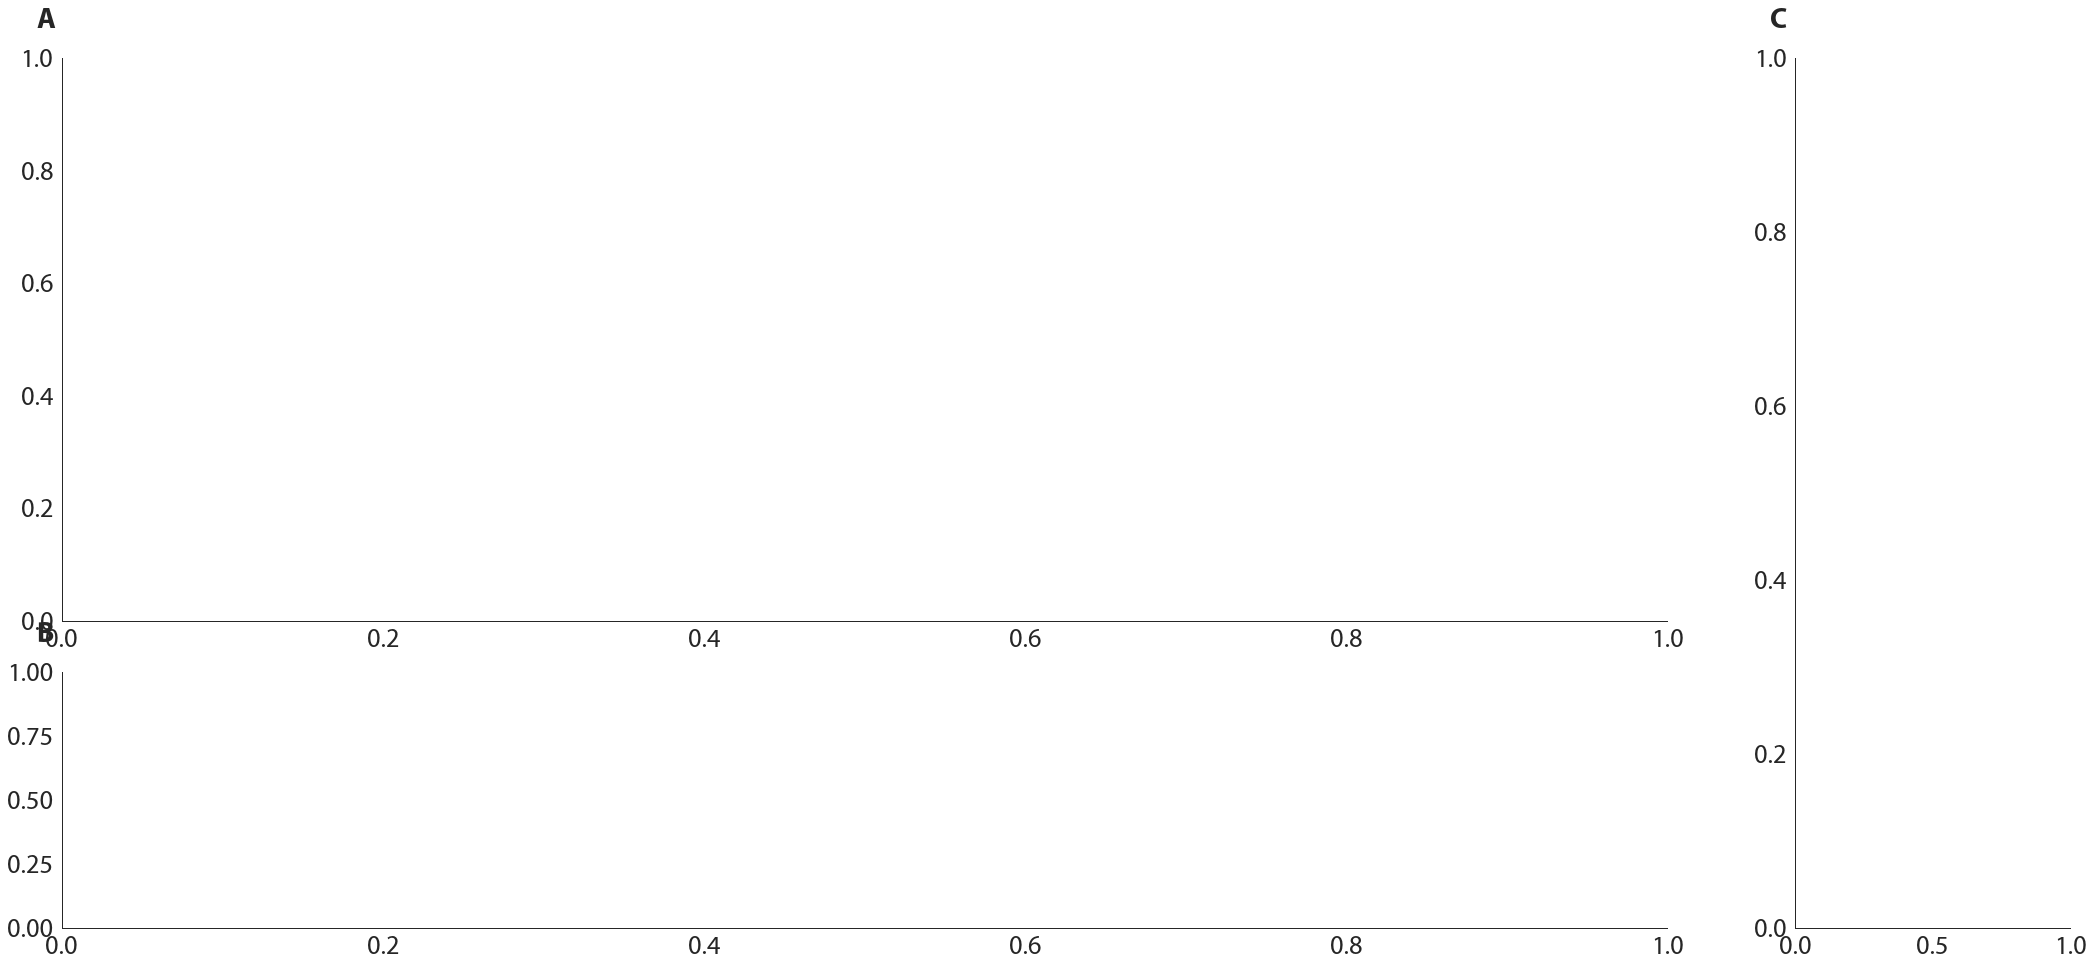

In [12]:
fig5 = plt.figure(figsize = (36, 16), constrained_layout=True) #36, 24
fig5.set_constrained_layout_pads(hspace=0.05, wspace=0.12)
gs = GridSpec(3,50,fig5)

ax5a = fig5.add_subplot(gs[0:2, 0:40])
ax5b = fig5.add_subplot(gs[2:3, 0:40])
ax5c = fig5.add_subplot(gs[:, 43:])

plt.rcParams['axes.titleweight'] = 'bold'
sns.despine(fig5)

figure_letter_x_offset = -25

def calc_figure_letter_offset(ax):
    return figure_letter_x_offset/ax.get_window_extent().width

ax5a.set_title('A', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax5a))
ax5b.set_title('B', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax5b))
ax5c.set_title('C', loc='left', **ax_letter_args).set_x(calc_figure_letter_offset(ax5c))

PB2
PB1
PA
HA
[<matplotlib.axis.XTick object at 0x7f3ed3d89520>, <matplotlib.axis.XTick object at 0x7f3ed3da8190>, <matplotlib.axis.XTick object at 0x7f3ed3dd7be0>, <matplotlib.axis.XTick object at 0x7f3ed3dd76a0>, <matplotlib.axis.XTick object at 0x7f3ed3d65d00>, <matplotlib.axis.XTick object at 0x7f3ed3d65430>]
HA_antigenic
HA_nonantigenic
NP
NA
M1
M2
NS1
NEP
PB1-F2
PA-X


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


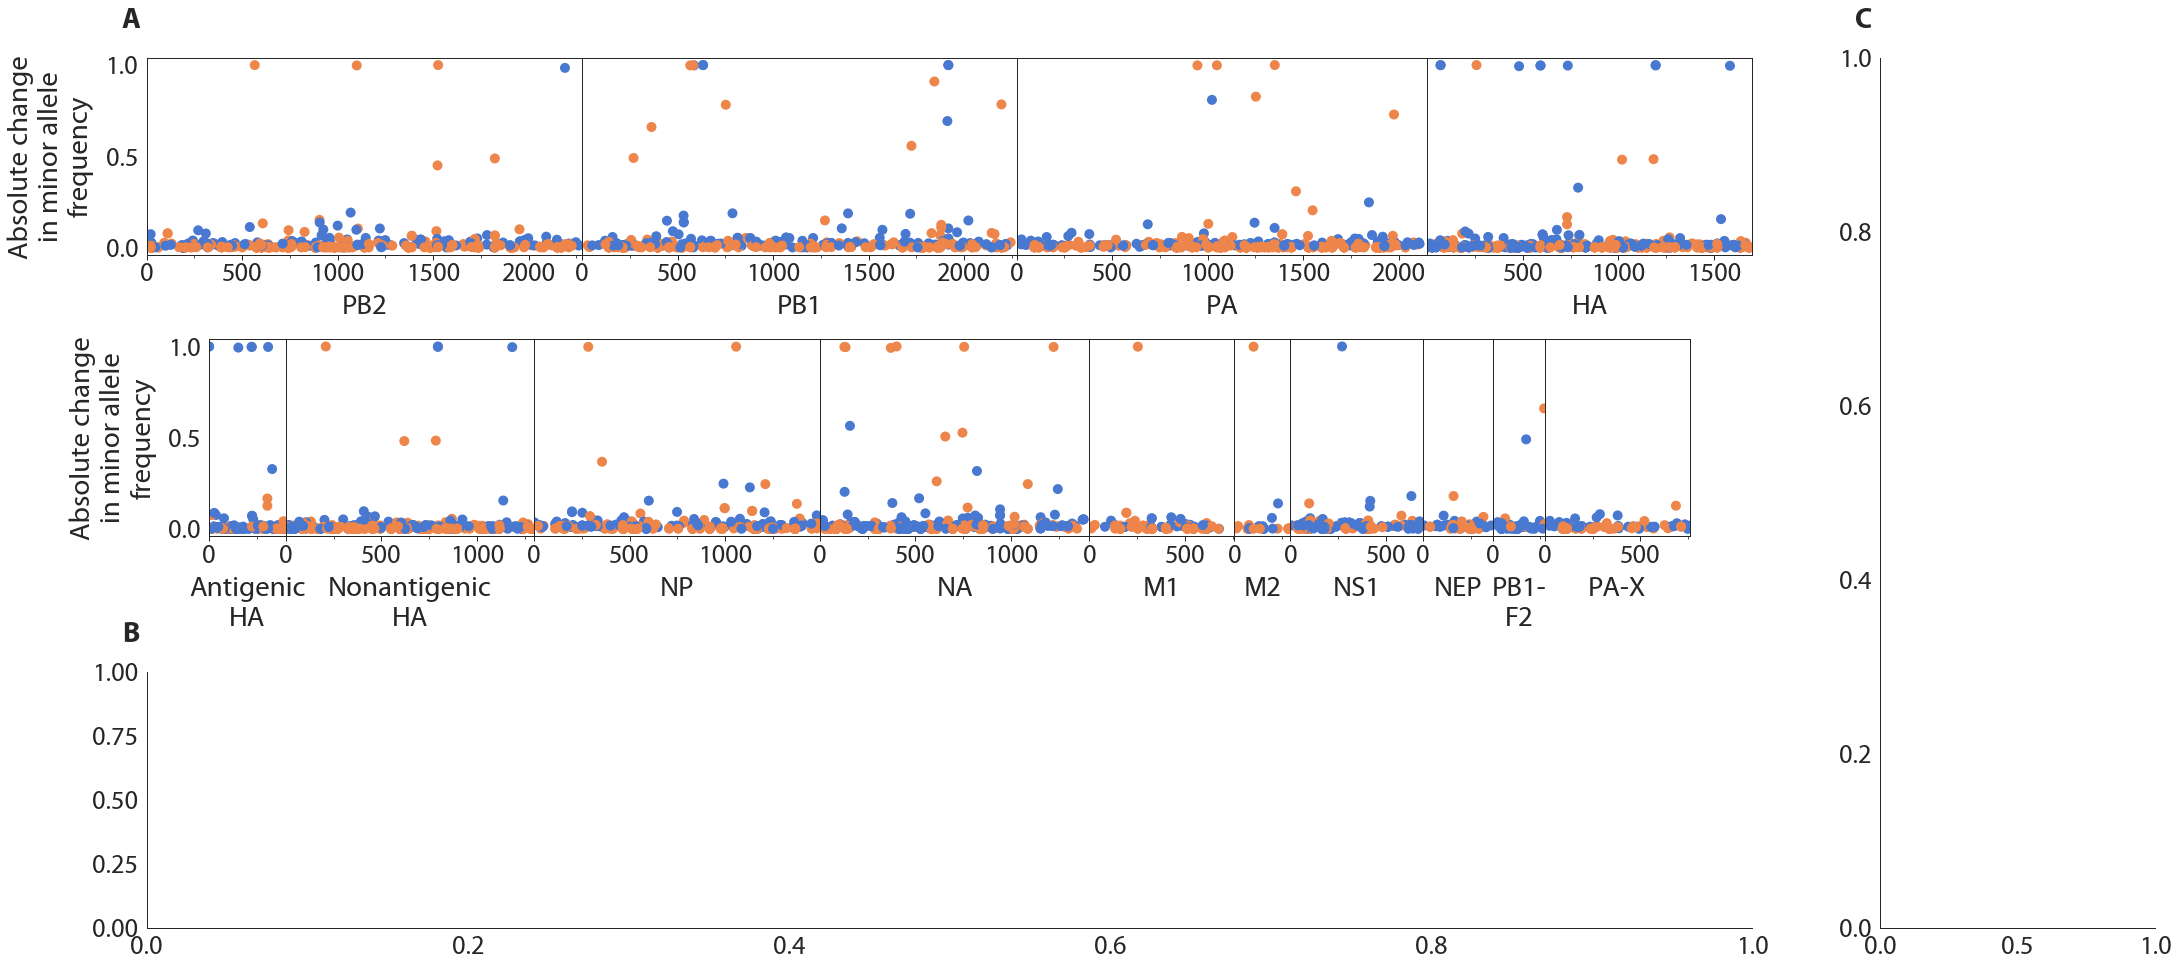

In [13]:
#fig 5a: manhattan


ax5a = makeManhattanPlot(ax=ax5a, y_label='Absolute change\nin minor allele\nfrequency',y='abs_SNP_frequency_difference', dotsize=100, data=transmissionSNPs, subtype=subtype, hue='AAtype', hue_order=['Nonsynonymous','Synonymous'])

fig5

In [14]:
# # tmp.columns    siteCorrectionFactor = {'Nonsynonymous':0.72,'Synonymous':0.28}
# siteColumn = {'Nonsynonymous':'N_sites_gene','Synonymous':'S_sites_gene'}
# divergencesGeneOrder = [gene for gene in antigenicGeneOrder if gene not in to_drop]
# segLengths = {'H3N2':(2316,2316,2209,1737,1541,1441,1002,865),'H1N1':(2316,2317,2208,1753,1540,1433,1002,865),'Influenza B':(2367,2340,2275,1853,1815,1530,1155,1062)}
# mappableSegLengths = {key:{seg:length for seg, length in zip(segOrder, lengths)} for key, lengths in segLengths.items()}

# variableTransmissionSNPs = transmissionSNPs.loc[(transmissionSNPs.abs_SNP_frequency_difference>0.01)&(transmissionSNPs.kind =='transmission')]

# divergences = variableTransmissionSNPs.groupby(['AAtype','subtype','antigenic_product','index','contact']).sum()['abs_SNP_frequency_difference'].reset_index().rename(columns={'abs_SNP_frequency_difference':'sum_divergence'})
# print (divergences.columns)
# divergences = divergences.merge(genes[['sampleID','product','N_sites_gene', 'S_sites_gene']], left_on=['index','antigenic_product'], right_on=['sampleID','product'], how='left')
# #     print([c for c in transmissionSNPs.columns if 'sites' in c])
# divergences['normalized_divergence'] = divergences.apply(lambda x: x.sum_divergence/(x[siteColumn[x.AAtype]]), axis=1)#(genelengths[x.subtype][x['product']]*siteCorrectionFactor[x.AAtype]),axis=1
# #Some super hacky code to ensure that genes with no SNPs are included in this analysis
# divergences['pairing_id'] = divergences['index'] + '|' + divergences.contact

# products = pd.DataFrame(divergences['product'].unique())
# subtypes = pd.DataFrame(divergences.subtype.unique())
# AAtypes = pd.DataFrame(divergences.AAtype.unique())
# pairings = pd.DataFrame(divergences.pairing_id.unique())

# all_possible_entries = products.merge(pairings, how='cross').merge(AAtypes, how='cross')
# all_possible_entries = all_possible_entries.rename(columns={'0_x':'antigenic_product','0_y':'pairing_id',0:'AAtype'})
# all_possible_entries = all_possible_entries.merge(divergences[['pairing_id','subtype','index','contact']], on='pairing_id',how='left')
# divergences = all_possible_entries.merge(divergences, on=['pairing_id','antigenic_product','AAtype', 'subtype','index','contact'], how='left').drop_duplicates().reset_index(drop=True).fillna(0)
# divergences.loc[divergences.subtype=='H3N2']

In [15]:
subtype

'H3N2'

<ipython-input-9-221c5e428fff>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transmittedSNPs['pairing_id'] = transmittedSNPs['index'] + '|' + transmittedSNPs.contact


bootstrapping...
PB2_Nonsynonymous: 5.63105768678556e-05, PB2_Synonymous: 8.564358893284103e-05
PB2_Nonsynonymous is less than PB2_Synonymous: Non-parametric paired bootstrap two-sided comparison, P_val=0.048 stat=1.00e+05
(means: PB2_Nonsynonymous is less than PB2_Synonymous: 8.30167719409797e-05 vs 0.0002682591634865439)
bootstrapping...
PB1_Nonsynonymous: 7.764933309311028e-05, PB1_Synonymous: 8.452534003906698e-05
PB1_Nonsynonymous is less than PB1_Synonymous: Non-parametric paired bootstrap two-sided comparison, P_val=0.16 stat=1.00e+05
(means: PB1_Nonsynonymous is less than PB1_Synonymous: 0.0001786818787424649 vs 0.00035327987728373233)
bootstrapping...
PB1-F2_Nonsynonymous: 0.0, PB1-F2_Synonymous: 0.0
PB1-F2_Nonsynonymous is equal to PB1-F2_Synonymous: Non-parametric paired bootstrap two-sided comparison, P_val=0.65 stat=1.00e+05
(means: PB1-F2_Nonsynonymous is less than PB1-F2_Synonymous: 0.00014022043198393816 vs 0.00030682708958819436)
bootstrapping...
PA_Nonsynonymous: 3.32

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


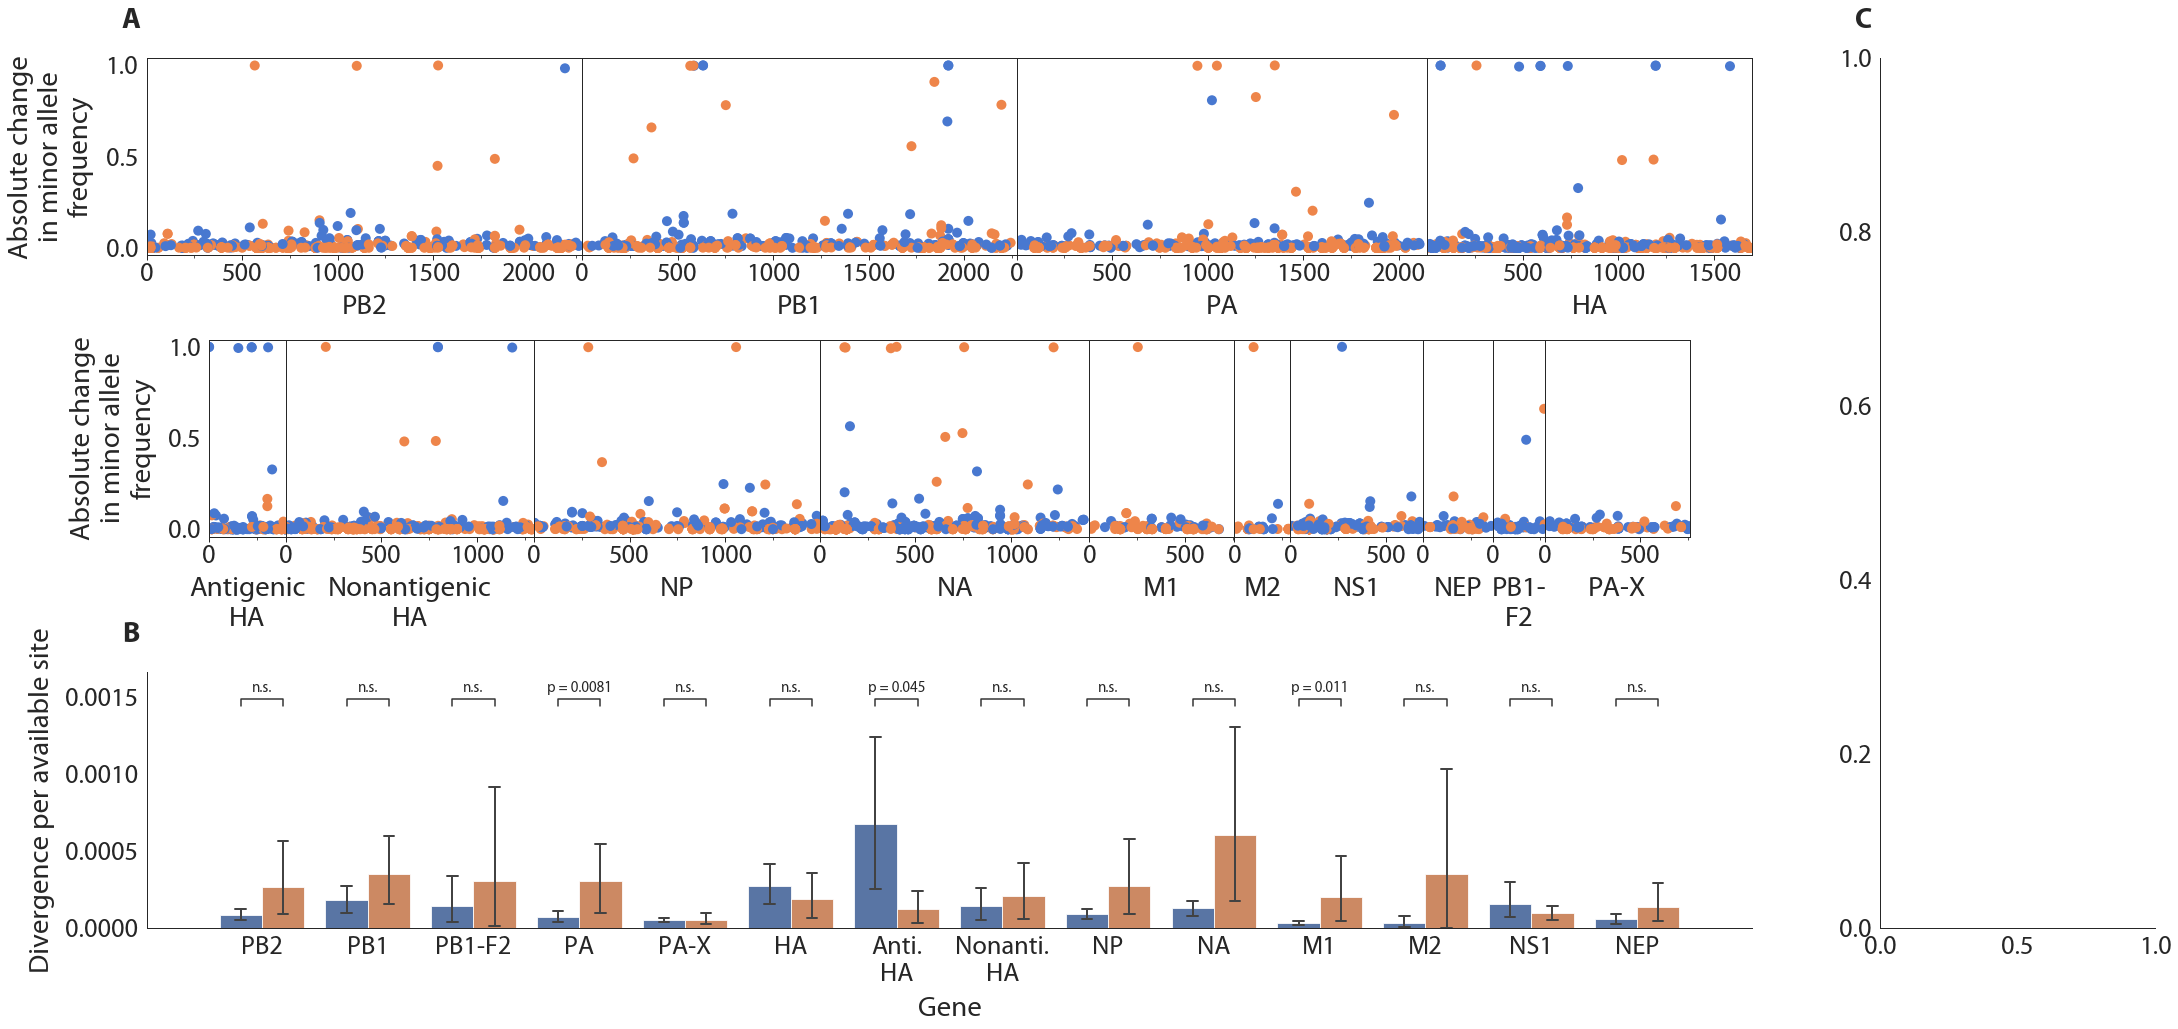

<Figure size 432x288 with 0 Axes>

In [16]:
#fig 5b: divergence by gene
#Fig 5b: Gene-by-gene ‘divergence’ (likely sum of N/S mutation separation, potentially N/S FST)
#This code should probably be refactored, as it's SUPER DUPER hacky. But it works!
# ax5b.clear()

import importlib
import chartannotator
importlib.reload(chartannotator)
from chartannotator import add_stat_annotation as sigBar

antiTransDict={'PB2': 'PB2',
 'PB1': 'PB1',
 'NP': 'NP',
 'HA': 'HA',
 'NA': 'NA',
 'PA': 'PA',
 'M1': 'M1',
 'M2': 'M2',
 'NS1': 'NS1',
 'NEP': 'NEP',
 'HA_antigenic': 'Antigenic\nHA',
 'HA_nonantigenic': 'Nonantigenic\nHA'}
# to_drop = ['PA-X','PB1-F2','BM2','NB']
# siteCorrectionFactor = {'Nonsynonymous':0.72,'Synonymous':0.28}

# tmpGeneOrder = [gene for gene in antigenicGeneOrder if gene not in to_drop]
# segLengths = {'H3N2':(2316,2316,2209,1737,1541,1441,1002,865),'H1N1':(2316,2317,2208,1753,1540,1433,1002,865),'Influenza B':(2367,2340,2275,1853,1815,1530,1155,1062)}
# mappableSegLengths = {key:{seg:length for seg, length in zip(segOrder, lengths)} for key, lengths in segLengths.items()}

# variableTransmissionSNPs = transmissionSNPs.loc[(transmissionSNPs.abs_SNP_frequency_difference>0.01)&(transmissionSNPs.kind =='transmission')]

# tmp = variableTransmissionSNPs.groupby(['AAtype','subtype','antigenic_product','index','contact']).sum()['abs_SNP_frequency_difference'].reset_index().rename(columns={'abs_SNP_frequency_difference':'sum_divergence'})
# tmp['normalized_divergence'] = tmp.apply(lambda x: x.sum_divergence/(genelengths[x.subtype][x['product']]*siteCorrectionFactor[x.AAtype]),axis=1)
# #Some super hacky code to ensure that genes with no SNPs are included in this analysis
# tmp['pairing'] = tmp['index']+tmp.contact

divergences = calc_pairing_divergences(transmissionSNPs, pairings=transmissionPairs[['index','contact']],subtype=subtype)

# cp = products.assign(key=0).merge(pairings.assign(key=0), how='left', on = 'key')
# cp = cp.assign(key=0).merge(AAtypes.assign(key=0),how='left',on='key').rename(columns={'0_x':'antigenic_product','0_y':'pairing',0:'AAtype'})

# a = cp.merge(tmp[['pairing_id','subtype','index','contact']], on='pairing_id',how='left')

# a = a.merge(tmp, on=['pairing_id','antigenic_product','AAtype', 'subtype','index','contact'], how='left').drop_duplicates().reset_index().fillna(0)
# ax5b.clear()

fig_args = {'x': 'product',
            'y': 'normalized_divergence',
            'hue':'AAtype',
            'data': divergences,
            'order': antigenicGeneOrder,
            'hue_order':['Nonsynonymous','Synonymous'],
            'ax': ax5b}

sns.barplot(**fig_args, **errorBarArgs)

comparisons = [((gene,'Nonsynonymous'),(gene,'Synonymous')) for gene in antigenicGeneOrder]

sigBar(**fig_args, use_fixed_offset_from_top=True, box_pairs=comparisons,test='paired_bootstrap', mult_comp_correction='fdr_tsbh')
# plt.suptitle(subtype, size=36,fontdict={'fontweight':'bold','fontsize':20})
ax5b.set_xlabel('Gene', labelpad=10)
ax5b.set_ylabel('Divergence per available site', labelpad=10)
ax5b.set_xticklabels(antigenicGeneNames_withMinor)
ax5b.legend().remove()
# # ax.legend(title='Amino Acid',title_fontsize=24,loc='lower center', bbox_to_anchor=(0.5, -.6))
fig5

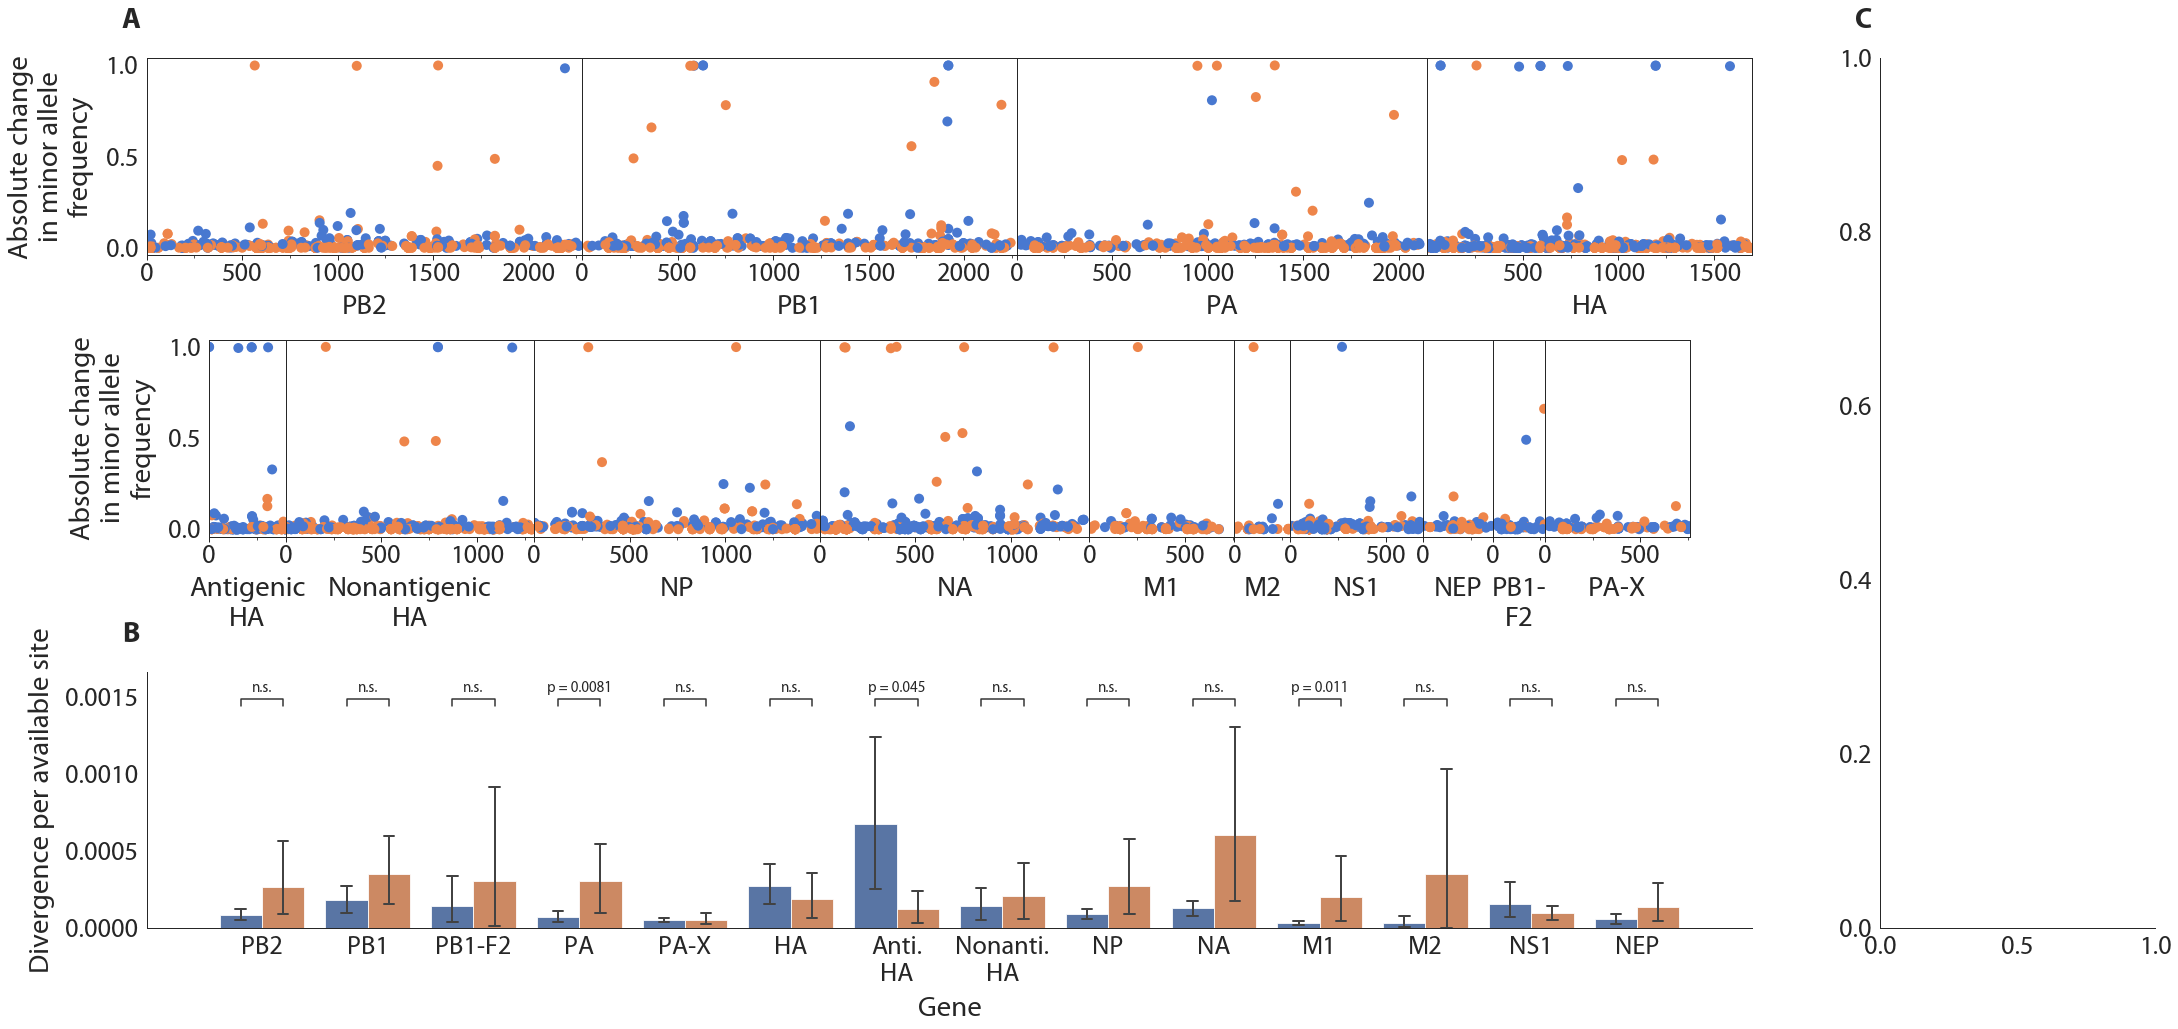

In [17]:
fig5

In [18]:
# [c for c in transmissionSNPs.rename(columns={'N_sites_gene_index':'N_sites_gene', 'S_sites_gene_index':'S_sites_gene'}).columns if 'sites' in c]
genes['S_sites_gene']#+genes.N_sites_gene
# print(402.0*.28)
# 86/402
503/2310

0.21774891774891775

In [19]:
pvalues = np.array([0.00736, 0.04092, 0.55688, 0.00152, 0.35276, 0.89224, 0.03436, 0.3302,  0.0128,  0.00376, 0.00084, 0.52652, 0.7848,  0.05704])
pvalues = np.array([0.04984, 0.15276, 0.65424, 0.00992, 0.85072, 0.41372, 0.01232, 0.60232, 0.07352, 0.01824, 0.00752, 0.59264, 0.35504, 0.15856])
pvalues = np.array([0.11308, 0.26664, 0.71116, 0.02492, 0.73312, 0.21408, 0.00508, 0.8006,  0.13924, 0.03196, 0.0134,  0.6132,  0.19824, 0.29024])
pvalues = np.array([0.12112, 0.2866,  0.72264, 0.02652, 0.67248, 0.19464, 0.00536, 0.82476, 0.15124, 0.0334,  0.016,   0.62372, 0.17824, 0.3148])
pvalues = np.array([0.13318, 0.3042,  0.71218, 0.00862, 0.6677,  0.10964, 0.00684, 0.82662, 0.16952, 0.03774, 0.0142,  0.66224, 0.093,   0.33174])
pvalues = np.array([0.05098, 0.15634, 0.64268, 0.00262, 0.93364, 0.28808, 0.0125,  0.61326, 0.07598, 0.0163,  0.00278, 0.64936, 0.30292, 0.21032]) #paired_bootstrap
pvalues = np.array([0.0452 , 0.1442,  0.6574,  0.0122,  0.9412,  0.3918,  0.0086,  0.6068,  0.0652,  0.0154,  0.005,   0.591,   0.3702,  0.1896]) #bootstrap
pvalues = np.array([0.05206, 0.15854, 0.6389,  0.0022,  0.93656, 0.28828, 0.01312, 0.61368, 0.07658, 0.01594, 0.00314, 0.65272, 0.30572, 0.20806])
pvalues = np.array([0.02822, 0.13482, 0.33286, 0.0008,  0.0611,  0.36276, 0.0323,  0.5053,  0.03798, 0.01054, 0.0,     0.00324, 0.70278, 0.0033])
pvalues = np.array([0.04936, 0.15934, 0.63756, 0.00272, 0.9374, 0.28698, 0.01328, 0.60626, 0.07568, 0.01718, 0.00338, 0.64904, 0.29472, 0.20682])
pvalues = np.array([0.04674, 0.15664, 0.6399, 0.00252, 0.93204, 0.29186, 0.0123, 0.6112, 0.0774, 0.01696, 0.00356, 0.64404, 0.29574, 0.20754])

In [20]:
# from statsmodels.stats.multitest import multipletests 
# # np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]*alpha
# # pvalues order: M1, PA, NA, HA_antigenic, PB2, NP (p=0.06 on the last one)
# multipletests(pvalues, method='fdr_tsbh')
# print(np.arange(1,15)/14*.05)
# .03436/0.01785714*.05

In [21]:
pvalues[np.argsort(pvalues)]/(np.arange(1,15)/14*.05)*.05

array([0.03528   , 0.02492   , 0.0574    , 0.05936   , 0.130872  ,
       0.1806    , 0.31328   , 0.363195  , 0.45400444, 0.414036  ,
       0.77789091, 0.74655   , 0.69358154, 0.93204   ])

In [22]:
# pvalues = np.array([0.04164, 0.15028, 0.67452, 0.0134, 0.93512, 0.4316, 0.0178, 0.78344, 0.06192, 0.01424, 0.0036, 0.58912, 0.41144, 0.2054])
# sortpvalues

In [23]:
# tmp.groupby(['AAtype','antigenic_product', 'subtype']).
# sns.histplot(tmp.loc[(tmp.AAtype=='Nonsynonymous')&(tmp['product']=='HA_nonantigenic')&(tmp.subtype=='H3N2'), 'N_sites_gene'])
# # tmp.columns
# tmp.loc[(tmp.AAtype=='Nonsynonymous')&(tmp['product']=='HA_nonantigenic')&(tmp.subtype=='H3N2')]

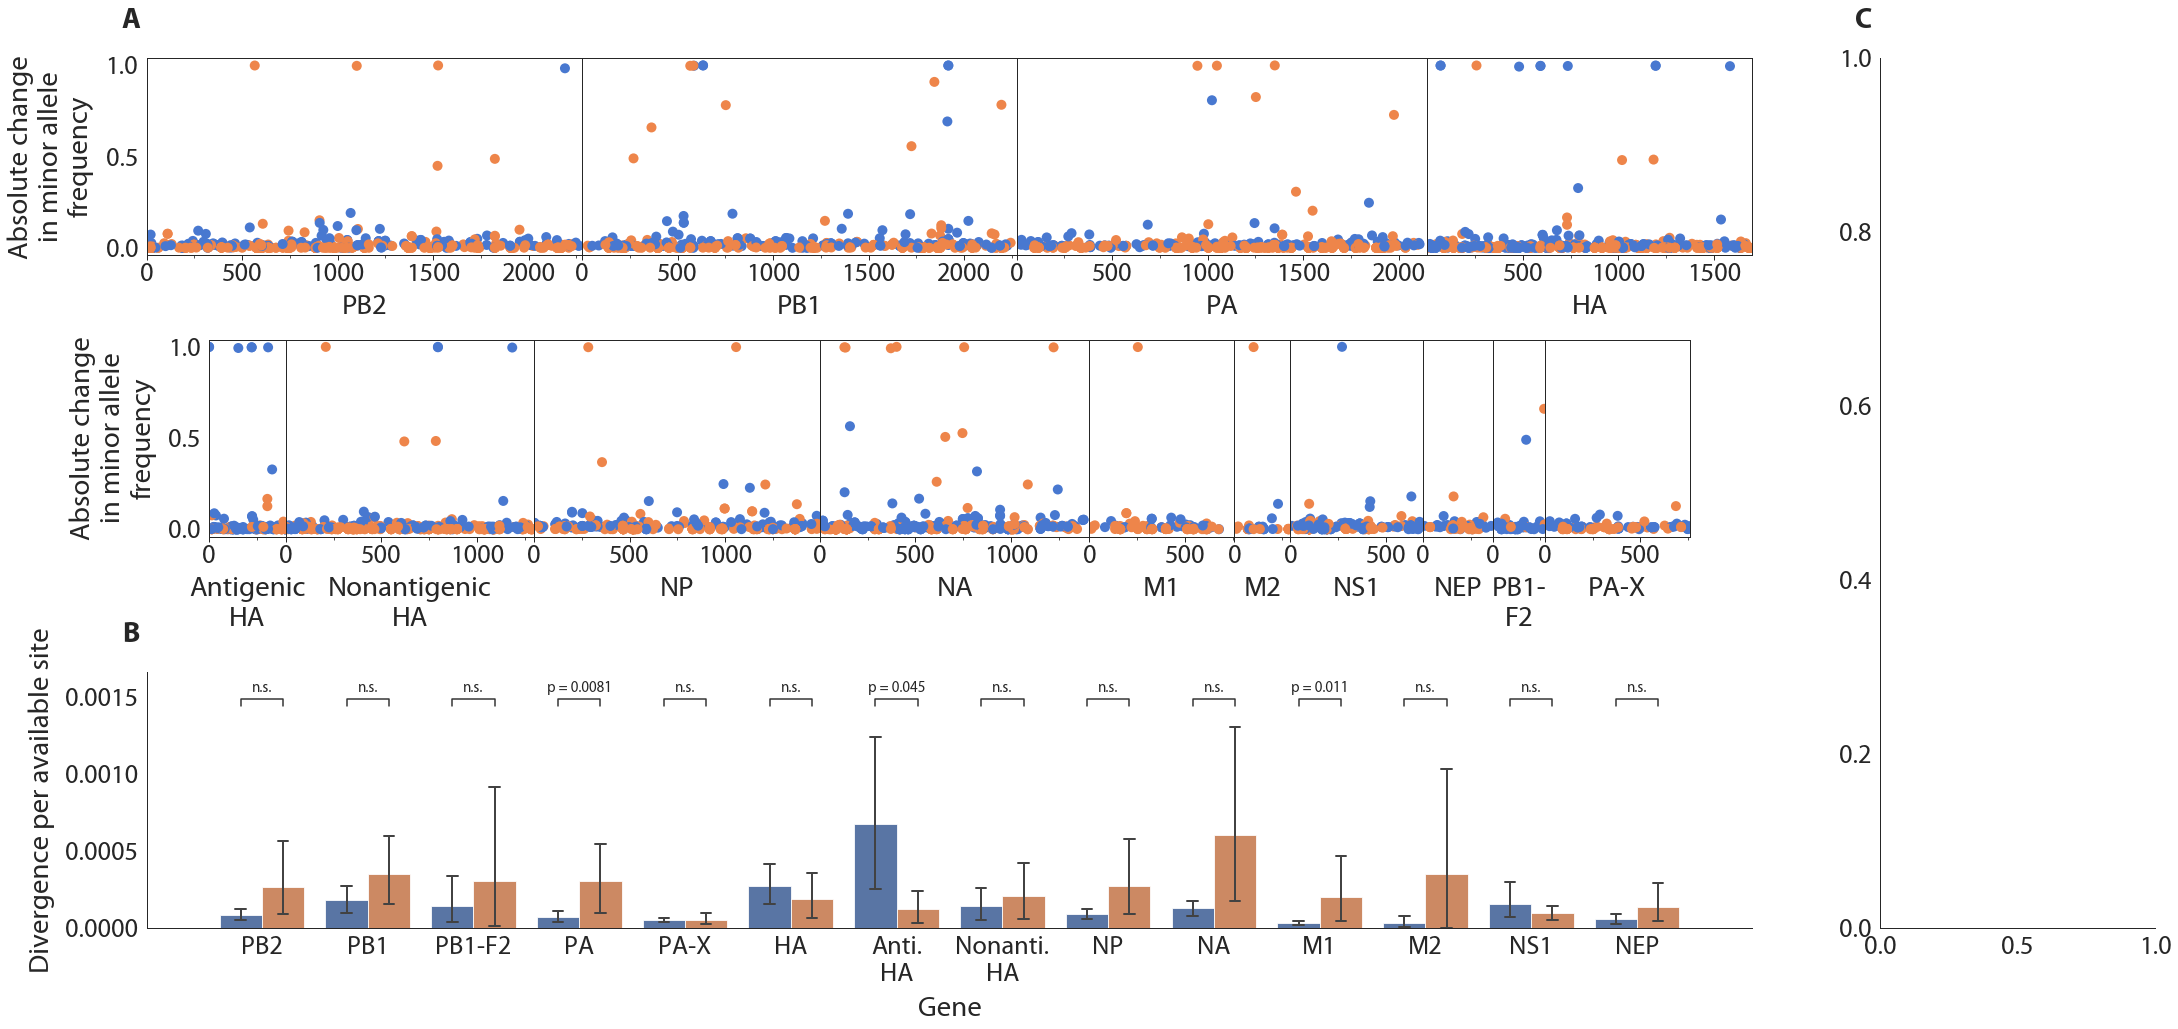

In [24]:
fig5

In [25]:
# #### print(list(transmissionSNPs.columns))
# 0.02178371841102037

# 0.02139848197170319
# 0.0005960845893524658

# SG2transmissionSNPs = pd.read_csv(dataFolder+'/transmissionSNPs_lenient_filter_SNPGenie2.gz', **read_tsv_args)


In [26]:
# SG2transmissionSNPs.loc[(SG2transmissionSNPs.subtype=='H3N2')&(SG2transmissionSNPs['antigenic_product'].isin(['HA_antigenic','HA_nonantigenic', 'HA']))&(SG2transmissionSNPs.AAtype != 'Out of reading frame')].drop_duplicates()
# SG2transmissionSNPs.loc[(SG2transmissionSNPs.subtype=='H3N2')&(SG2transmissionSNPs['antigenic_product'] != SG2transmissionSNPs['product'])&(SG2transmissionSNPs.AAtype != 'Out of reading frame'), ['chrom', 'pos','antigenic_product','product','codon','abs_SNP_frequency_difference']]
# SG2transmissionSNPs.loc[(SG2transmissionSNPs.subtype=='H3N2')&(SG2transmissionSNPs['product']=='HA')]
# transmissionSNPs.loc[(transmissionSNPs.subtype=='H3N2')&(~transmissionSNPs.SNPkey.isin(SG2transmissionSNPs.SNPkey))]

In [27]:
# 0            17VR005325:17VR005779:MP:525:C:M1

transmissionSNPs.groupby('codon').count()

,index,contact,chrom,pos,ref_nuc,alt_nuc,qual,GT_index,GQ_index,SDP_index,...,Xue_divergence_per_day_contact,Xue_synon_divergence_per_day_contact,Xue_nonsynon_divergence_per_day_contact,divergence_rate_contact,synon_divergence_rate_contact,nonsynon_divergence_rate_contact,log(piN/piS)_contact,abs_SNP_frequency_difference,SNP_frequency_directional_change,log_abs_SNP_frequency_difference
codon,,,,,,,,,,,,,,,,,,,,,
0.0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2.0,4,4,4,4,4,4,4,3,3,3,...,2,2,2,2,2,2,4,4,4,4
3.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4.0,11,11,11,11,11,11,11,9,9,9,...,11,11,11,10,10,10,11,11,11,11
5.0,5,5,5,5,5,5,5,2,2,2,...,5,5,5,4,4,4,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741.0,4,4,4,4,4,4,4,2,2,2,...,4,4,4,4,4,4,4,4,4,4
743.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
747.0,1,1,1,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [28]:
genes.loc[(genes.subtype=='H3N2')&(genes['product']=='HA_antigenic'),'N_sites_gene'].std()

0.6163329630802058

In [29]:
subtype='H3N2'
import pickle
with open(f'10000randompairings_{subtype}_controlled_distances.pkl', 'rb') as p:
    random_pairings = pickle.load(p)

In [30]:
pd.DataFrame(random_pairings[0])
np.log((1.47/.72)/(0.47/0.28))

0.19582337622782636

In [31]:
random_pairings[0]

,product,AAtype,num_of_sites,sum_divergence,normalized_divergence,index,contact,distance,subtype_index
pairing_id,,,,,,,,,
17VR014177|17VR014558,HA_nonantigenic,Synonymous,375.044718,0.0000,0.000000,17VR014177,17VR014558,1.709951,H3N2
17VR014177|17VR014558,HA_nonantigenic,Nonsynonymous,923.955282,1.0079,0.001091,17VR014177,17VR014558,1.709951,H3N2
17VR014177|17VR014558,NS1,Synonymous,200.083043,0.9603,0.004800,17VR014177,17VR014558,1.709951,H3N2
17VR014177|17VR014558,NS1,Nonsynonymous,489.916957,0.0127,0.000026,17VR014177,17VR014558,1.709951,H3N2
17VR014177|17VR014558,HA,Synonymous,485.551191,0.0133,0.000027,17VR014177,17VR014558,1.709951,H3N2
...,...,...,...,...,...,...,...,...,...
17VR014028|17VR014171,NEP,Nonsynonymous,263.077039,0.0434,0.000165,17VR014028,17VR014171,10.018100,H3N2
17VR014028|17VR014171,M2,Synonymous,82.957960,0.0150,0.000181,17VR014028,17VR014171,10.018100,H3N2
17VR014028|17VR014171,M2,Nonsynonymous,208.042040,1.0211,0.004908,17VR014028,17VR014171,10.018100,H3N2


In [32]:
import pickle
with open(f'10000randompairings_{subtype}_controlled_distances.pkl', 'rb') as p:
    random_pairings = pickle.load(p)
# random_H3N2_pairings_df = pd.DataFrame(columns = random_pairings[0].reset_index().columns)
random_H3N2_pairings_df = pd.concat(random_pairings)
# for i, draw in enumerate(tqdm(random_pairings)):
#     draw = draw.groupby(['product', 'AAtype']).mean().reset_index()
#     draw['draw_id'] = i
# #     if len(draw) == len(random_pairings[0]):
#     random_H3N2_pairings_df = random_H3N2_pairings_df.append(draw)
random_H3N2_pairings_df1 = pd.read_csv('/mnt/d/orchards/10000_random_H3N2_log_ratios.tsv', **read_tsv_args)

In [33]:
random_H3N2_pairings_df2 = pd.read_csv('/mnt/d/orchards/10000_random_H3N2_log_ratios.tsv', **read_tsv_args)
random_H3N2_pairings_df2

,Unnamed: 0,bootstrap_id,product,log_divergence_ratio
0,0,0,HA,0.453267
1,1,0,HA_antigenic,1.107954
2,2,0,HA_nonantigenic,-0.313083
3,3,0,M1,-0.481606
4,4,0,M2,-1.203821
...,...,...,...,...
139995,139995,9999,PA,-1.034424
139996,139996,9999,PA-X,-0.632853
139997,139997,9999,PB1,0.524372
139998,139998,9999,PB1-F2,-0.391898


In [34]:
# backup=random_H3N2_pairings_df.copy()
random_H3N2_pairings_df = random_H3N2_pairings_df2.reset_index(drop=True)
# random_H3N2_pairings_df['pairing_id'] = np.arange(len(random_H3N2_pairings_df))//(len(random_H3N2_pairings_df['product'].unique())*2)
# random_H3N2_pairings_df = random_H3N2_pairings_df.pivot(values='normalized_divergence', index=['product','bootstrap_id'] , columns='AAtype')
# random_H3N2_pairings_df['diff'] = random_H3N2_pairings_df['Nonsynonymous'] - random_H3N2_pairings_df['Synonymous']
# random_H3N2_pairings_df['log_diff'] = np.log(random_H3N2_pairings_df['Nonsynonymous'])-np.log(random_H3N2_pairings_df['Synonymous'])
# random_H3N2_pairings_df = random_H3N2_pairings_df.reset_index()

bootstrap_size = (len(random_H3N2_pairings_df)/len(random_H3N2_pairings_df['product'].unique()))

divergences = divergences.groupby(['product','AAtype']).mean().reset_index()
divergences = divergences.pivot(values=['normalized_divergence'], index='product', columns='AAtype')['normalized_divergence'].reset_index()
divergences['diff'] = divergences['Nonsynonymous'] - divergences['Synonymous']
divergences['log_diff'] = np.log(divergences['Nonsynonymous'])-np.log(divergences['Synonymous'])
divergences = divergences.reset_index()

divergences['pvalue_log_diff_high'] = divergences.apply(lambda x: sum(random_H3N2_pairings_df.loc[random_H3N2_pairings_df['product']==x['product'], 'log_divergence_ratio'] > x['log_diff']), axis=1)/bootstrap_size
divergences['pvalue_log_diff_low'] = divergences.apply(lambda x: sum(random_H3N2_pairings_df.loc[random_H3N2_pairings_df['product']==x['product'], 'log_divergence_ratio'] < x['log_diff']), axis=1)/bootstrap_size
divergences['pvalue_log_diff'] = divergences[['pvalue_log_diff_high', 'pvalue_log_diff_low']].min(axis=1)*2
divergences

AAtype,index,product,Nonsynonymous,Synonymous,diff,log_diff,pvalue_log_diff_high,pvalue_log_diff_low,pvalue_log_diff
0,0,HA,0.000272,0.000186,0.000085,0.376137,0.5575,0.4425,0.8850
1,1,HA_antigenic,0.000673,0.000125,0.000548,1.681867,0.0043,0.9957,0.0086
2,2,HA_nonantigenic,0.000144,0.000207,-0.000063,-0.363417,0.7013,0.2987,0.5974
3,3,M1,0.000030,0.000201,-0.000171,-1.904700,0.9995,0.0005,0.0010
4,4,M2,0.000032,0.000347,-0.000315,-2.380032,0.9995,0.0005,0.0010
5,5,NA,0.000128,0.000607,-0.000478,-1.555053,0.9997,0.0003,0.0006
6,6,NEP,0.000059,0.000139,-0.000079,-0.848613,0.7030,0.2970,0.5940
7,7,NP,0.000091,0.000275,-0.000185,-1.111884,0.7640,0.2360,0.4720
8,8,NS1,0.000156,0.000096,0.000060,0.487061,0.0889,0.9111,0.1778
9,9,PA,0.000071,0.000305,-0.000234,-1.458662,0.9970,0.0030,0.0060


In [35]:
# pairings=list()
# for pair in random_pairings:
#     pair['log_divergence'] = np.log(normalized_diverg)
    
# x = [pair.reset_index().groupby(['product','AAtype']).mean() for pair in random_pairings]

In [36]:
# df['log_divergence'] =np.log(df.normalized_divergence)
# df = df.reset_index()

In [37]:
# for f, x in df.groupby(['product']):
# #     p.loc[p.AAtype=='Nonsynonymous', 'log_divergence'] - p.loc[p.AAtype=='Synonymous', 'log_divergence']
#     print (f)
# #     print (x.loc[x.AAtype=='Nonsynonymous', 'log_divergence'])
#     print(x.loc[x.AAtype=='Nonsynonymous', 'log_divergence'])# - x.loc[x.AAtype=='Synonymous', 'log_divergence'])
#     break
    
# ratio_distributions = df.groupby('product').apply(lambda x: x.loc[x.AAtype=='Nonsynonymous', 'log_divergence'].values - x.loc[x.AAtype=='Synonymous', 'log_divergence'].values)

In [38]:
# x = pd.DataFrame()
# x['product'] = ratio_distributions.index
# x['low_end_percentile'] = ratio_distributions.apply(np.percentile, args=[2.5]).values
# x['high_end_percentile'] = ratio_distributions.apply(np.percentile, args=[97.5]).values
# x['actual_value'] = divergences['log_diff']


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


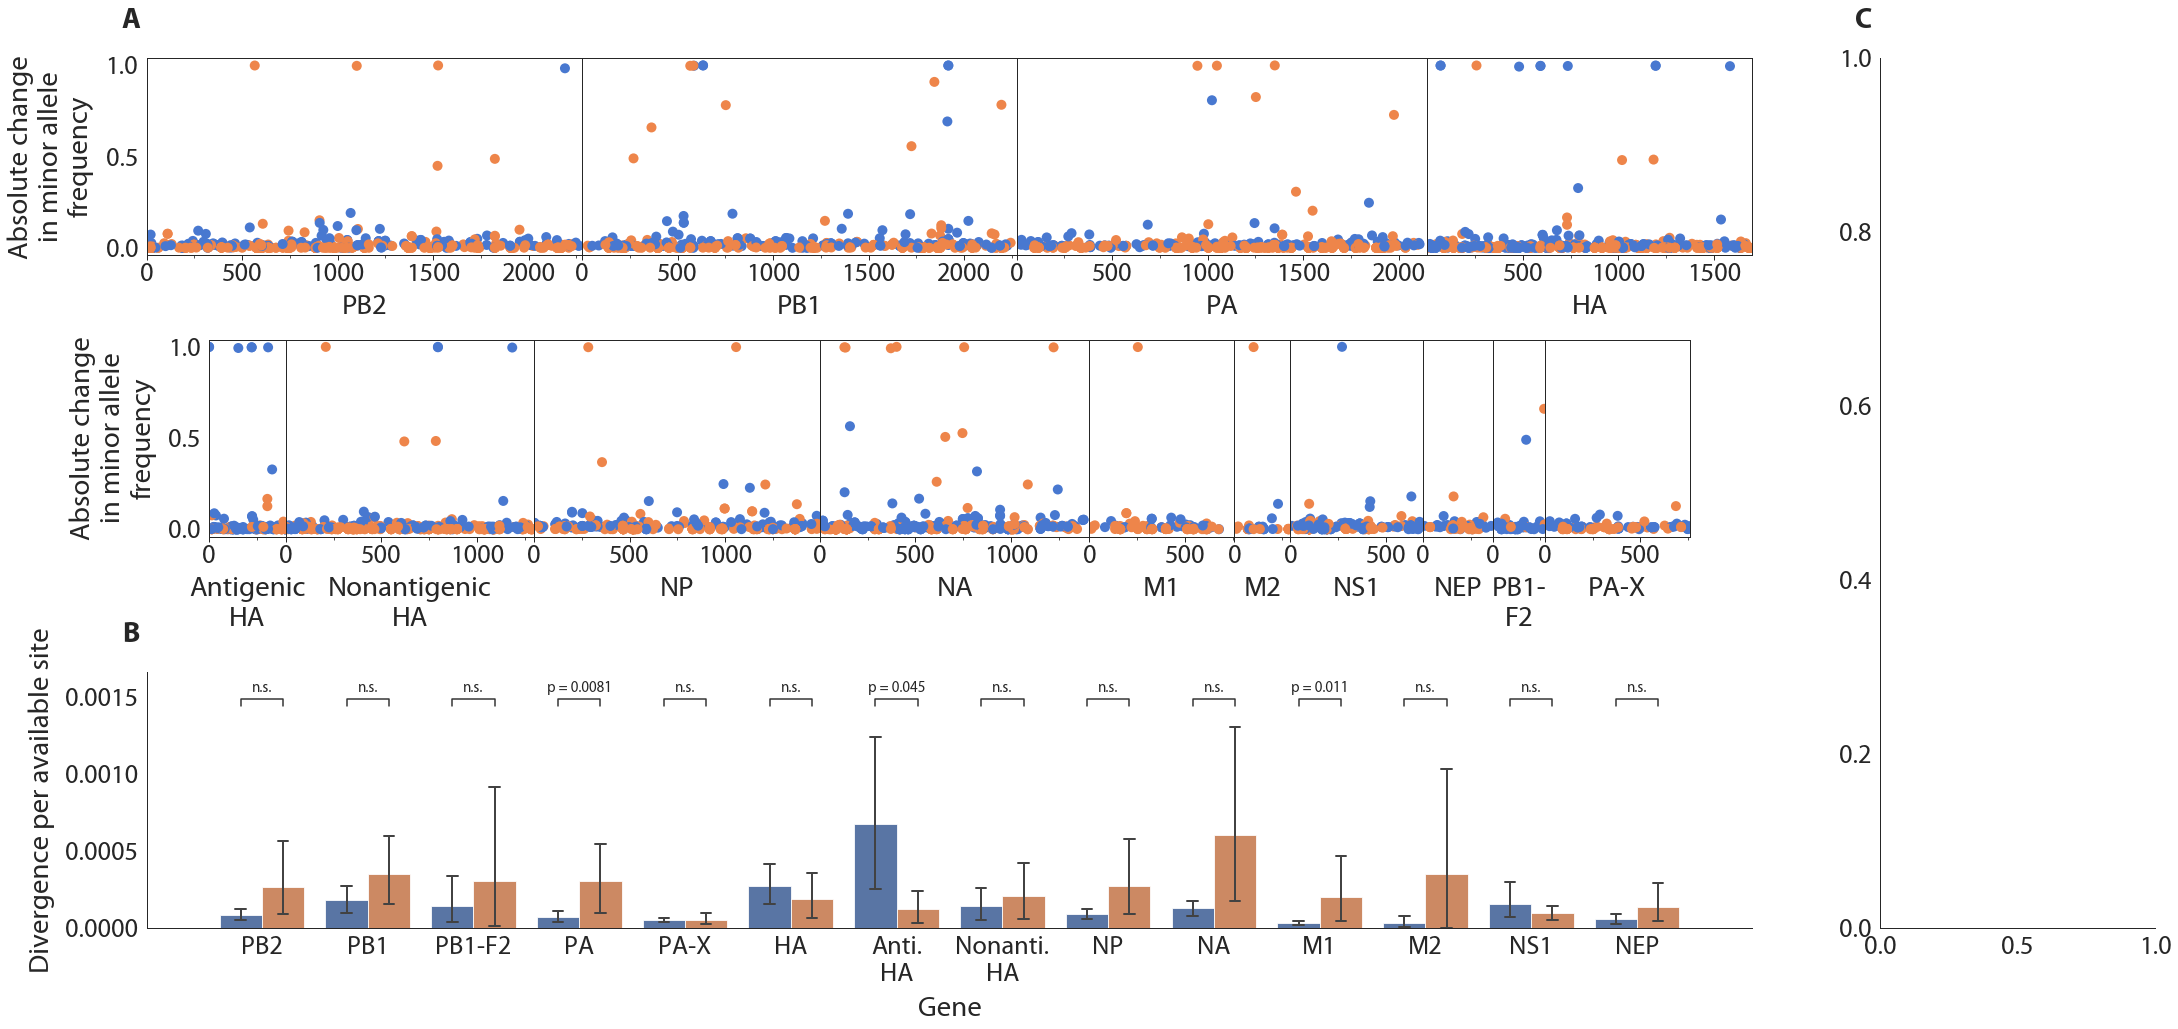

In [39]:
fig5
# plt.figure(figsize=(24,12))
# sns.violinplot(x='product', y='normalized_divergence',hue='AAtype',data=df.reset_index(), split=True)

In [40]:
vert_gene_names=['PB2','PB1','PB1-F2','PA','PA-X',
                 'HA', 'Anti. HA', 'Nonanti. HA',
                 'NP','NA','M1','M2','NS1','NEP']

fig_args = {'y': 'product',
            'x': 'log_diff',
            'data': divergences,
            'bootstrapped_random_data': random_H3N2_pairings_df.rename(columns={'log_divergence_ratio':'log_diff'}),
            'order': antigenicGeneOrder,
            'ax': ax5c}

ax5c = prob_range_violin_plot_vert(**fig_args, mc='fdr_tsbh')
rcParams["mathtext.default"] = 'regular'
xlabel = r'$log\left(\frac{Nonsynonymous\ divergence}{Synonymous\ divergence}\right)$'

ax5c.axvline(0, color='black',zorder=1, alpha=.7, ls='--')
# ax5c.set_xlim(-5.9,5.9)
ax5c.set_xlim(-3,3)
ax5c.set_ylabel(None)
ax5c.set_xlabel(xlabel, labelpad=10)
ax5c.set_yticklabels(vert_gene_names)

[6.000e-04 1.000e-03 1.000e-03 6.000e-03 8.600e-03 2.000e-02 6.020e-02
 1.386e-01 1.778e-01 2.690e-01 4.720e-01 5.940e-01 5.974e-01 8.850e-01]


[Text(0, 0, 'PB2'),
 Text(0, 1, 'PB1'),
 Text(0, 2, 'PB1-F2'),
 Text(0, 3, 'PA'),
 Text(0, 4, 'PA-X'),
 Text(0, 5, 'HA'),
 Text(0, 6, 'Anti. HA'),
 Text(0, 7, 'Nonanti. HA'),
 Text(0, 8, 'NP'),
 Text(0, 9, 'NA'),
 Text(0, 10, 'M1'),
 Text(0, 11, 'M2'),
 Text(0, 12, 'NS1'),
 Text(0, 13, 'NEP')]

In [41]:
# list(transmissionSNPs.columns)
# columns_of_interest = ['index','contact','chrom','pos','antigenic_product','ref_nuc','alt_nuc','depth_index','RT_index','AD_index','SNP_frequency_index','depth_contact','RT_contact','AD_contact','SNP_frequency_contact']
# # transmissionSNPs.loc[(transmissionSNPs.subtype==subtype)&(transmissionSNPs['product']=='HA')].sort_values('abs_SNP_frequency_difference')
# transmissionSNPs.loc[transmissionSNPs['product']!=transmissionSNPs['product'], ['subtype','product','antigenic_product']]

In [42]:
# p = np.array([0.000e+00, 0.000e+00, 2.000e-04, 1.400e-03, 2.380e-02, 2.460e-02, 2.540e-02,
#  7.100e-02, 1.404e-01, 2.306e-01, 2.690e-01, 3.250e-01, 4.788e-01, 7.184e-01])
from statsmodels.stats.multitest import multipletests
# print (sorted(p))
for method in ['bonferroni', 'sidak','holm-sidak','holm','simes-hochberg','hommel','fdr_bh','fdr_by','fdr_tsbh','fdr_tsbky','fdr_gbs']:
    print(method)
    print(multipletests(sorted(pvalues), method=method, alpha=.05))
# multipletests(sorted(pvalues), method='fdr_tsbh')
# print(np.arange(1,15)/14*.05)
# pvalues

bonferroni
(array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False]), array([0.03528, 0.04984, 0.1722 , 0.23744, 0.65436, 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ]), 0.0036571031913835705, 0.0035714285714285718)
sidak
(array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False]), array([0.0347079 , 0.04870297, 0.15908761, 0.21296027, 0.48836626,
       0.67626601, 0.90791646, 0.9614803 , 0.99202616, 0.9926165 ,
       0.9999982 , 0.99999938, 0.99999948, 1.        ]), 0.0036571031913835705, 0.0035714285714285718)
holm-sidak
(array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False]), array([0.0347079 , 0.04530425, 0.13801314, 0.17151798, 0.38039673,
       0.51569266, 0.74408014, 0.80373564, 0.87390009, 0.87390009,
       0.97714901, 0.97714901, 0.97714901, 0.97714901]), 0.003657103

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


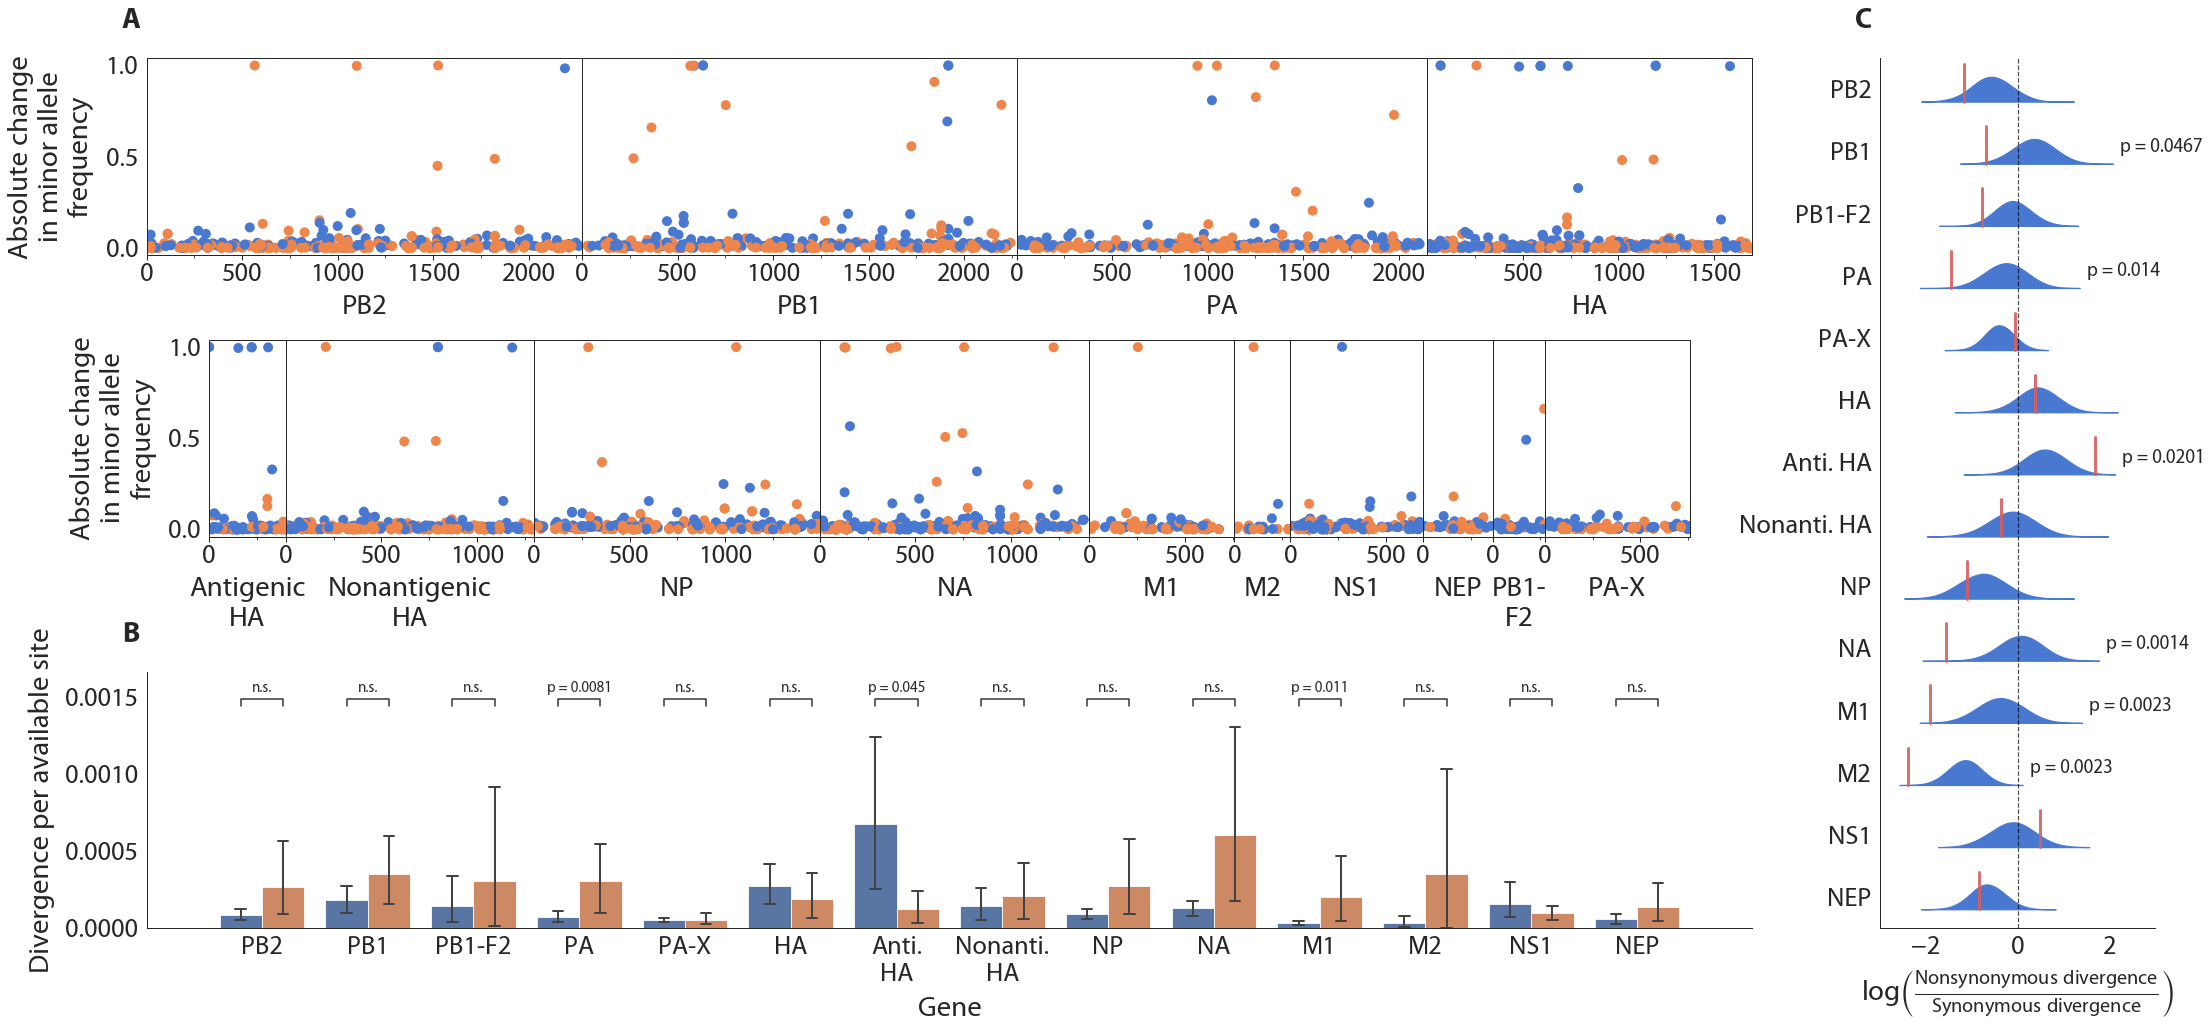

In [43]:
fig5
#print all pvalues for c

### Relevant question:
#For each gene, we want to know if nonsynonymous mutations are more frequent than synonymous mutations
#We might think that this is difference is just due to incorrect pairing
#If that were the case, than Nonsynon mutations/differences would occur at the same rate between random pairs as between our samples
#If the pairs are correct, then we would expect mutation rates to be lower across the board
#If selection is occuring, then nonsynon mutation rates would decline less than synon mutation rates
#So, on average, real pairings with selection will see an increase in nonsynon/synon ratio compared to random pairings.
#Real pairings w/o selection will see the same or decreased ratio, with decreased divergence

random_transmissionSNPs.loc[(random_transmissionSNPs.AAtype=='Nonsynonymous')&(random_transmissionSNPs['product']=='HA')].groupby('pairing').sum().normalized_divergence

In [45]:
t3_columns = ['Mutation','In-season Prevalence','Function/Region']
t3_values = [['N8D','Reached 5% prevalence by Jan 2019 (case was in Jan 2018)','Glycosylation site$^1$'],
#              ['G145S and I230V†', 'Sporadically','Antigenic cluster-defining mutation sites; 145 on antigenic ridge$^2$'],
             ['V182A', 'No','Antigenic site D$^3$'],
             ['R383Q', 'Sporadically','Stem alpha-helix'],
             ['D513N','No','Stem']]

In [46]:
t3 = pd.DataFrame(t3_values, columns=t3_columns)
t3.style

,Mutation,In-season Prevalence,Function/Region
0,N8D,Reached 5% prevalence by Jan 2019 (case was in Jan 2018),Glycosylation site$^1$
1,V182A,No,Antigenic site D$^3$
2,R383Q,Sporadically,Stem alpha-helix
3,D513N,No,Stem


In [50]:
fig5.savefig('/mnt/d/orchards/fig5.svg', format='svg')

<ipython-input-50-7d280178b3f8>:1: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig5.savefig('/mnt/d/orchards/fig5.svg', format='svg')


In [48]:
transmissionSNPs.loc[(transmissionSNPs['product'].isin(['HA_antigenic', 'HA_nonantigenic'])) & (transmissionSNPs.abs_SNP_frequency_difference > .7)&(transmissionSNPs.subtype=='H3N2'), ['inGenePos','AAstr','product','SNP_frequency_index','SNP_frequency_contact','distance', 'index','contact','referenceFile']]

,inGenePos,AAstr,product,SNP_frequency_index,SNP_frequency_contact,distance,index,contact,referenceFile
1843,0.0,N0D,HA_antigenic,1.0000,0.0008,8.0336,18VR002648,18VR002213,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
1919,0.0,N0D,HA_antigenic,1.0000,0.0003,8.7980,18VR002648,18VR002214,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
2554,1185.0,D395N,HA_nonantigenic,0.0018,0.9979,20.5392,18VR003776,18VR004244,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
3200,796.0,R265Q,HA_nonantigenic,0.0002,1.0000,2.8650,18VR004088,18VR004483,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
3476,796.0,R265Q,HA_nonantigenic,0.0002,0.9978,8.0366,18VR004088,18VR004484,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
3847,223.0,V74A,HA_antigenic,0.9976,0.0000,17.2204,18VR004315,18VR004934,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
3944,223.0,V74A,HA_antigenic,0.9976,0.0002,2.9638,18VR004315,18VR004928,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Hong...
9115,309.0,I103V,HA_antigenic,0.9973,0.0002,39.3798,19VR006682,19VR006679,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Sing...
9178,209.0,L69L,HA_nonantigenic,0.0000,0.9997,39.3798,19VR006682,19VR006679,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Sing...
9179,153.0,S51G,HA_antigenic,0.0011,0.9947,39.3798,19VR006682,19VR006679,/mnt/d/orchards/h1n1/orchards_run19H3N2/A_Sing...


In [49]:
list(transmissionSNPs.columns)

['index',
 'contact',
 'chrom',
 'pos',
 'ref_nuc',
 'alt_nuc',
 'qual',
 'GT_index',
 'GQ_index',
 'SDP_index',
 'depth_index',
 'RD_index',
 'AD_index',
 'SNP_frequency_index',
 'PVAL_index',
 'RBQ_index',
 'ABQ_index',
 'RDF_index',
 'RDR_index',
 'ADF_index',
 'ADR_index',
 'product',
 'inGenePos',
 'refAA',
 'codon',
 'altAA',
 'AAstr',
 'AAtype',
 'referenceFile',
 'segment',
 'subtype',
 'CT_index',
 'sample_date_index',
 'decimalDate',
 'seasonalDate_index',
 'week_index',
 'season',
 'household',
 'participant_ID_index',
 'age_index',
 'gender_index',
 'time_of_symptom_onset_index',
 'recieved_flu_vaccine_index',
 'school_index',
 'jackson_score_index',
 'antipyretic_use_index',
 'flu_antiviral_treatment',
 'school_absence_index',
 'number_in_household',
 'recent_travel',
 'isIndexCase_index',
 '%ofHHinfected',
 'age_category_index',
 'days_since_symptom_onset_index',
 'symptom_severity_index',
 'saw_a_doctor_index',
 'taken_on_hh_infection_day',
 'clade',
 'subclade',
 'trans